In [13]:
from src.Prep import *
from src.Time_Series_Helper_Funcs import *
from src.Regression_Helper_Funcs import *
import warnings
warnings.filterwarnings('ignore')

/Users/jenniferpaige/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [22]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# DATA
## Load in, clean, sort, and filter data

In [14]:
df = prep()

1 of 11 |    Reading in first dataset. 
             Using 4/60 features/columns: 'Installation Date', 'System Size', 'Total Installed Price' , 'Customer Segment' 
             Changing -9999 values to null
2 of 11 |    Reading in second dataset. 
             Using 4/60 features/columns: 'Installation Date', 'System Size', 'Total Installed Price' , 'Customer Segment' 
             Changing -9999 values to null
3 of 11 |    Concatenating datasets together
4 of 11 |    Refining to only RES Customer Segment
5 of 11 |    Cleaning up column names
6 of 11 |    Sorting values by installation_date
7 of 11 |    Assigning installation_date as index
8 of 11 |    Replacing all null values with median values from same year
9 of 11 |    Adusting prices for inflation
10 of 11|    Creating target variable: cost_per_watt
11 of 11|    Removing > 1600 outliers above $25 per watt
Prep complete 
 ------------------------------------------------------------


In [15]:
df

,system_size,total_installed_price,customer_segment,date,adj_installed_price,cost_per_watt
installation_date,,,,,,
1998-01-30,4.251500,17439.0,RES,1998-01-30,27838.84,6.55
1998-04-08,2.331600,30941.0,RES,1998-04-08,49119.27,21.07
1998-04-30,4.181100,17439.0,RES,1998-04-30,27684.65,6.62
1998-07-07,2.282400,24500.0,RES,1998-07-07,38727.26,16.97
1998-07-10,3.113265,17439.0,RES,1998-07-10,27565.91,8.85
...,...,...,...,...,...,...
2018-12-31,5.760000,22000.0,RES,2018-12-31,22590.03,3.92
2018-12-31,4.410000,21610.0,RES,2018-12-31,22189.57,5.03
2018-12-31,8.640000,45958.6,RES,2018-12-31,47191.20,5.46


In [18]:
y = time_frame(df)
y = y.dropna()

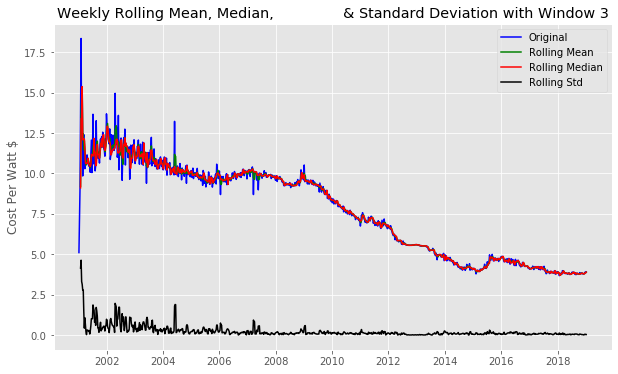

Results of Dickey-Fuller Test:
Test Statistic            0.121576
p-value                   0.967504
#Lags Used               22.000000
#Observations Used      916.000000
Critical Value (1%)      -3.437509
Critical Value (5%)      -2.864700
Critical Value (10%)     -2.568453
dtype: float64


In [20]:
rolling_plot(y)
dfuller_test(y)

## Check for Stationarity

In [21]:
test_for_stationarity(y)

ADF p-value: 0.97
Time Series is not stationary. Fail to reject ADF H0


In [36]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(y.cost_per_watt.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.121576
p-value: 0.967504


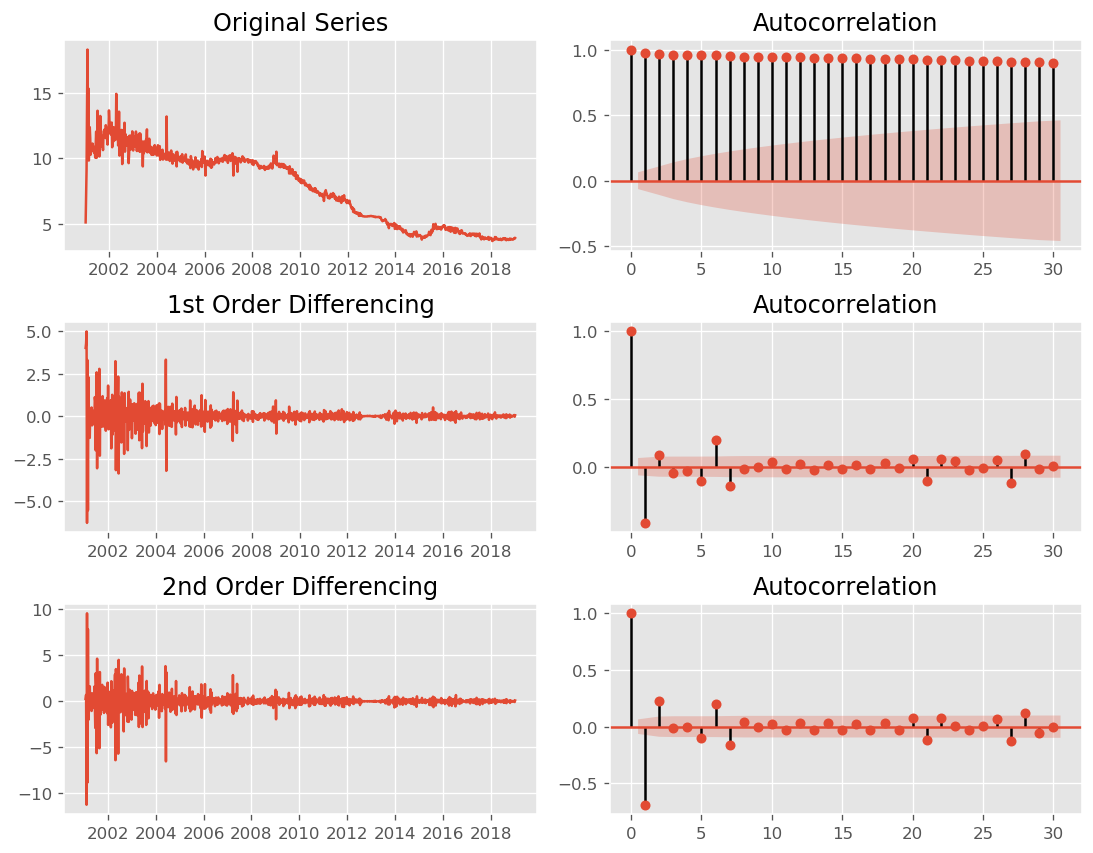

In [27]:
# Original Series
fig, axes = plt.subplots(3, 2, constrained_layout=True)
axes[0, 0].plot(y.cost_per_watt); axes[0, 0].set_title('Original Series')
plot_acf(y.cost_per_watt, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y.cost_per_watt.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y.cost_per_watt.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y.cost_per_watt.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y.cost_per_watt.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [31]:
from pmdarima.arima.utils import ndiffs
cost = y.cost_per_watt

## Adf Test
ndiffs(cost, test='adf') 

1

In [32]:
# KPSS test
ndiffs(cost, test='kpss')

1

In [43]:
# PP test:
ndiffs(cost, test='pp')

0

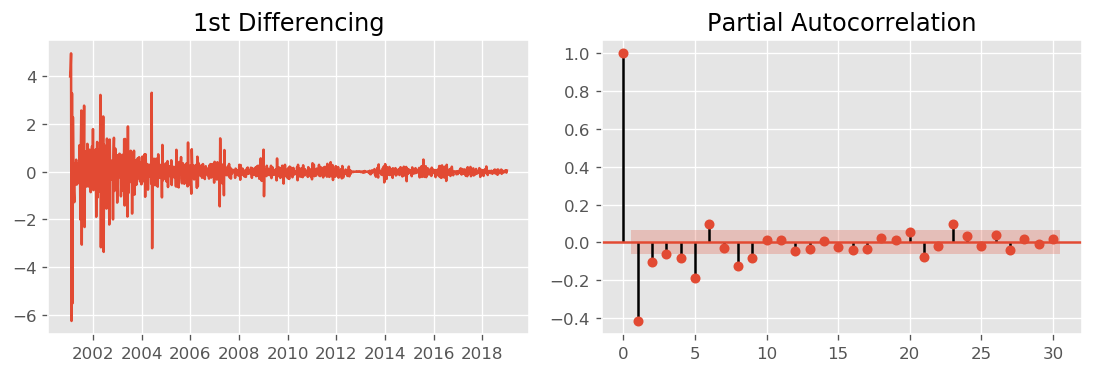

In [48]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, constrained_layout=True)
axes[0].plot(y.cost_per_watt.diff()); axes[0].set_title('1st Differencing')
#axes[1].set(ylim=(0,5))
plot_pacf(y.cost_per_watt.diff().dropna(), ax=axes[1])
plt.show()

#### lag1 is significant
#### p = 1

In [47]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

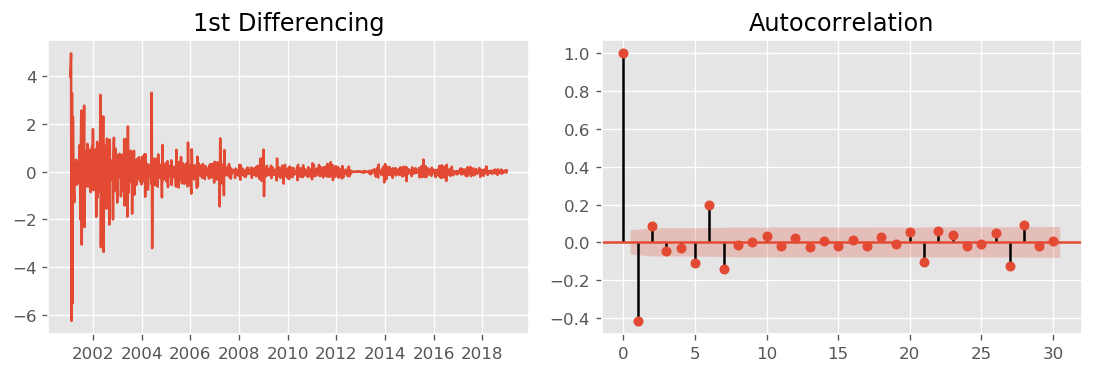

In [51]:
fig, axes = plt.subplots(1, 2, constrained_layout=True)
axes[0].plot(y.cost_per_watt.diff()); axes[0].set_title('1st Differencing')
plot_acf(y.cost_per_watt.diff().dropna(), ax=axes[1])
plt.show()

#### lag1 is significant
#### q = 1

In [62]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(y.cost_per_watt, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.cost_per_watt   No. Observations:                  938
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -723.904
Method:                       css-mle   S.D. of innovations              0.523
Date:                Sun, 26 Apr 2020   AIC                           1455.808
Time:                        16:20:06   BIC                           1475.183
Sample:                             1   HQIC                          1463.195
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0080      0.002     -3.872      0.000      -0.012      -0.004
ar.L1.D.cost_per_watt     0.1660      0.040      4.162      0.000       0.088       0.244
ma.L1.D.

#### P values are 0! 

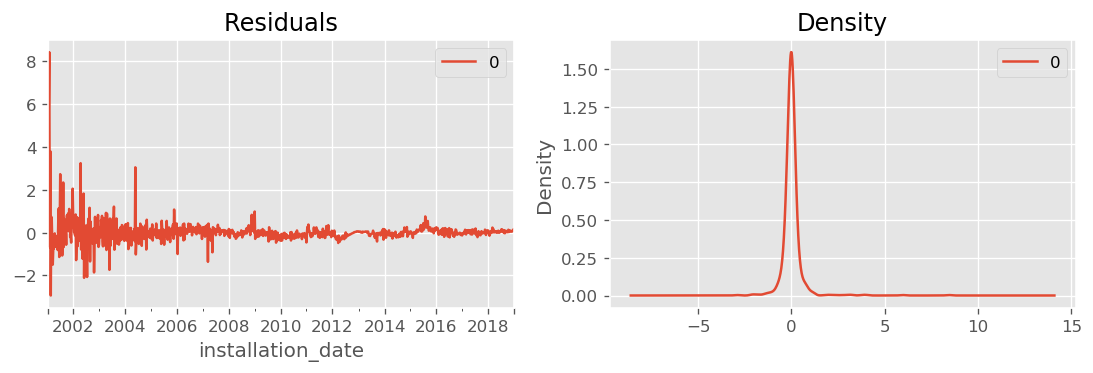

In [64]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, constrained_layout=True)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

#### mean near zero
#### ________ variance 


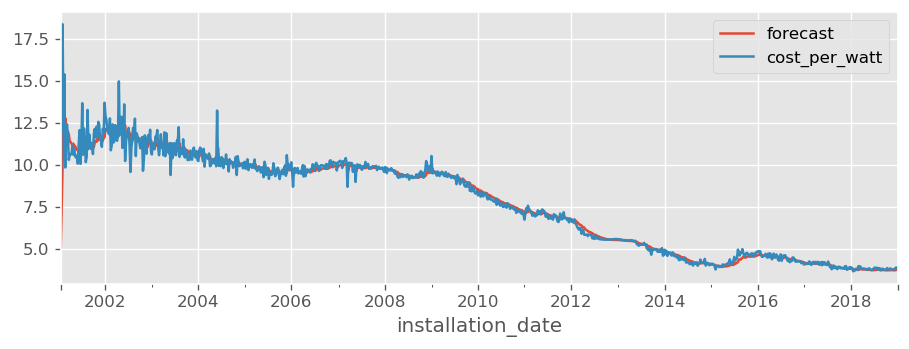

In [72]:
model_fit.plot_predict(dynamic=False)
plt.show()

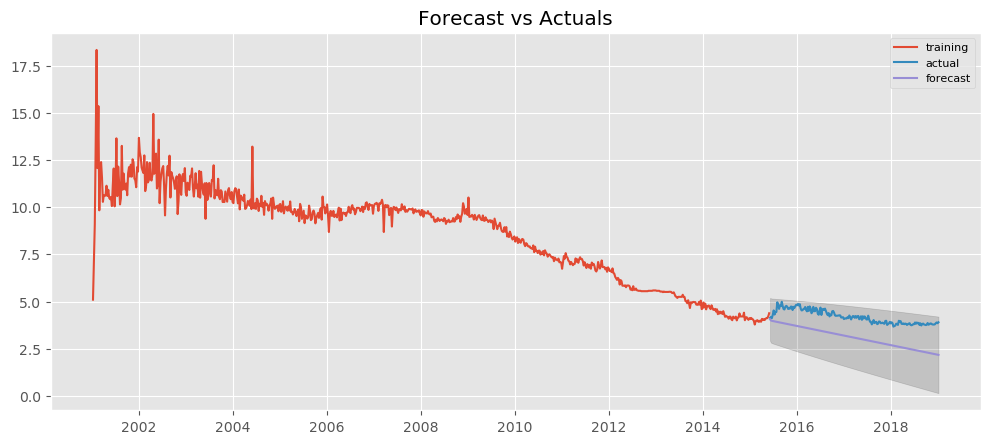

In [84]:
from statsmodels.tsa.stattools import acf

# Create Training and Test set
train = y.cost_per_watt[:round(len(y)*.8)]
test = y.cost_per_watt[round(len(y)*.8):]

# Build ARIMA Model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(188,alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, laqbel='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper right', fontsize=8)
plt.show()

#### Forecast consistently below actual <br>
#### Will try adding a constant

                             ARIMA Model Results                              
Dep. Variable:       D2.cost_per_watt   No. Observations:                  749
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -705.095
Method:                       css-mle   S.D. of innovations              0.617
Date:                Wed, 29 Apr 2020   AIC                           1422.189
Time:                        15:34:28   BIC                           1449.902
Sample:                             2   HQIC                          1432.868
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.297e-05   4.81e-05     -0.893      0.372      -0.000    5.13e-05
ar.L1.D2.cost_per_watt    -0.5909      0.041    -14.520      0.000      -0.671      -0.511
ar.L

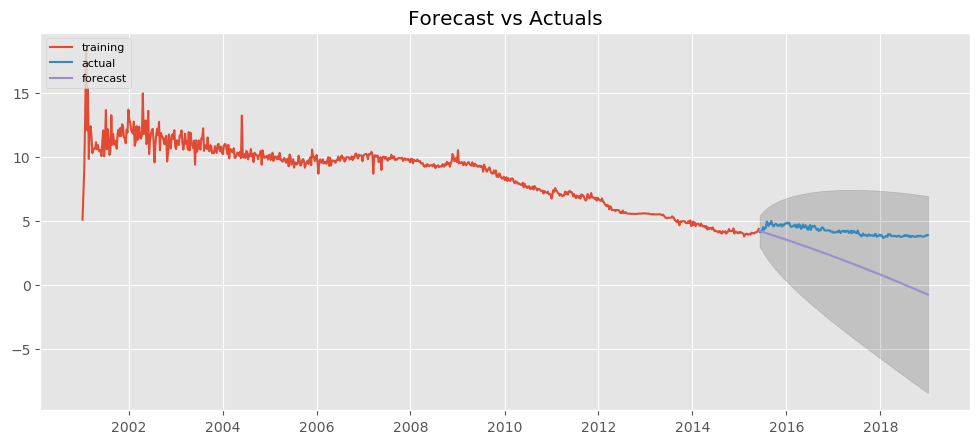

In [121]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(188, alpha=0.05)  # 95% conf

# Convert to pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### AIC reduced!
#### P-Values are less than .05
#### MAPE, Correlation and Min-Max Error can be used

In [123]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)             
    mae = np.mean(np.abs(forecast - actual))    
    mpe = np.mean((forecast - actual)/actual)   
    rmse = np.mean((forecast - actual)**2)**.5  
    corr = np.corrcoef(forecast, actual)[0,1]
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    mse = mean_squared_error(actual, forecast)
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax, 'mse':mse})

forecast_accuracy(fc, test.values)

{'mape': 0.5788739017843179,
 'me': -2.3264872232401763,
 'mae': 2.327637663710055,
 'mpe': -0.5785954462220285,
 'rmse': 2.591112411969378,
 'acf1': 0.9715414493919123,
 'corr': 0.894201003444195,
 'minmax': 0.5788720635137904,
 'mse': 6.713863531461768}

#### MAPE of 58% means the model is 42% accurate in predicting the next 188 observations
#### bad.

In [122]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y.cost_per_watt, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1455.808, BIC=1475.183, Time=0.279 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1798.607, BIC=1808.295, Time=0.050 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1614.163, BIC=1628.694, Time=0.101 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1470.982, BIC=1485.513, Time=0.178 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1796.611, BIC=1801.455, Time=0.029 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1456.935, BIC=1481.154, Time=0.768 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1457.510, BIC=1481.729, Time=0.508 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1457.860, BIC=1477.235, Time=0.347 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1594.513, BIC=1613.888, Time=0.135 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1448.990, BIC=1478.

<Figure size 1080x360 with 0 Axes>

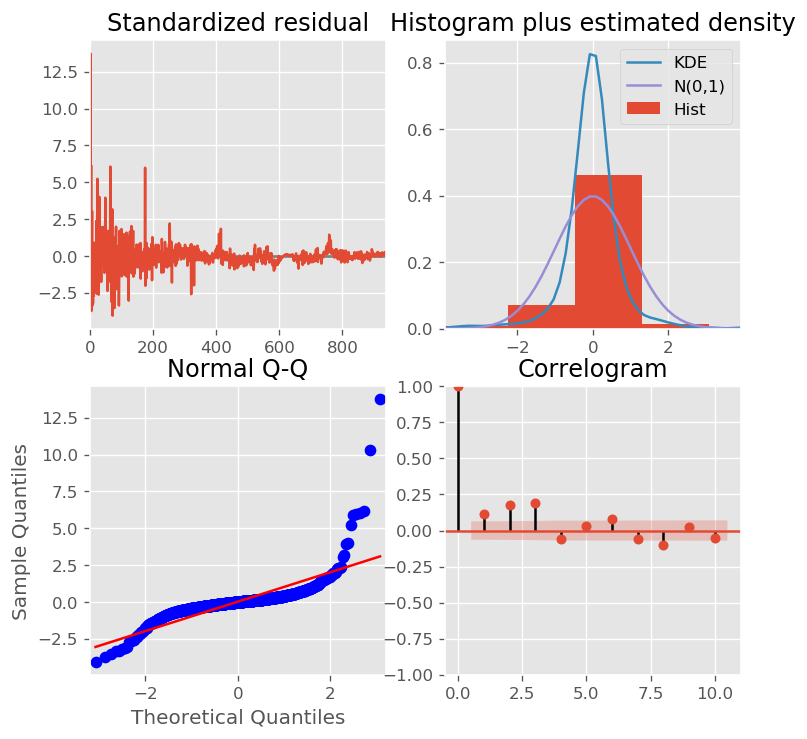

In [93]:
plt.figure(constrained_layout=True)
model.plot_diagnostics(figsize=(7,7))
plt.show()

#### Standardized Residuals seem to fluctuate around 0 
#### Estimated Density seems normal in distribution and have a mean of zero
#### The Deviation in Theoretical Quantiles suggest the distribution is skewed.

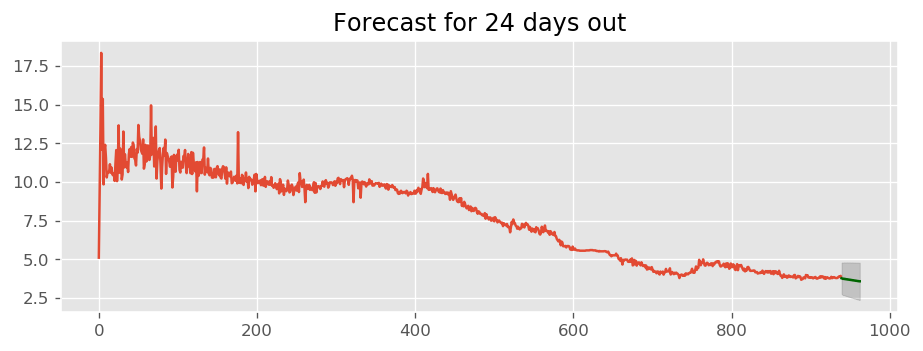

In [115]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(y.cost_per_watt), len(y.cost_per_watt)+n_periods)

# Convert to a pandas series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(y.cost_per_watt.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Forecast for 24 days out")
plt.show()